# Automated Essay Scoring Model

## Project Objectives

1. Develop a machine learning model to automatically score essays.
2. Use features based on content, grammar, and other writing aspects.
3. Implement the model using Python and popular data science libraries.
4. Prepare the model for use with the ASAP-AES dataset from Kaggle.


## Step 1: Import Required Libraries


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import re


In [23]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mehak\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mehak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 2: Load and Preprocess Data

In [31]:
train_df = pd.read_excel('train.xlsx')
test_df = pd.read_excel('test.xlsx')


In [33]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [36]:
train_df['processed_essay'] = train_df['essay'].apply(preprocess_text)
test_df['processed_essay'] = test_df['essay'].apply(preprocess_text)

## Step 3: Feature Engineering


In [39]:
def extract_features(essay):
    # Word count
    word_count = len(word_tokenize(essay))
    
    # Sentence count
    sentence_count = len(sent_tokenize(essay))
    
    # Average sentence length
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0
    
    # Unique word count
    unique_words = set(word_tokenize(essay))
    unique_word_count = len(unique_words)
    
    # Lexical diversity (unique words / total words)
    lexical_diversity = unique_word_count / word_count if word_count > 0 else 0
    
    return pd.Series({
        'word_count': word_count,
        'sentence_count': sentence_count,
        'avg_sentence_length': avg_sentence_length,
        'unique_word_count': unique_word_count,
        'lexical_diversity': lexical_diversity
    })

In [41]:
train_features = train_df['processed_essay'].apply(extract_features)
test_features = test_df['processed_essay'].apply(extract_features)


In [43]:
train_df = pd.concat([train_df, train_features], axis=1)
test_df = pd.concat([test_df, test_features], axis=1)

## Step 4: TF-IDF Vectorization

In [46]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')


In [48]:
tfidf_train = tfidf.fit_transform(train_df['processed_essay'])
tfidf_test = tfidf.transform(test_df['processed_essay'])

In [50]:
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=tfidf.get_feature_names_out())
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names_out())

In [52]:
train_df = pd.concat([train_df, tfidf_train_df], axis=1)
test_df = pd.concat([test_df, tfidf_test_df], axis=1)

## Step 5: Prepare Data for Model Training


In [65]:
numerical_features = ['word_count', 'sentence_count', 'avg_sentence_length', 'unique_word_count', 'lexical_diversity']


In [67]:
X_numerical = train_df[numerical_features]
X_tfidf = tfidf_train_df


In [71]:
X_numerical_train, X_numerical_val, X_tfidf_train, X_tfidf_val, y_train, y_val = train_test_split(
    X_numerical, X_tfidf, train_df['domain1_score'], test_size=0.2, random_state=42)

In [73]:
scaler = StandardScaler()
X_numerical_train_scaled = scaler.fit_transform(X_numerical_train)
X_numerical_val_scaled = scaler.transform(X_numerical_val)

In [75]:
X_train = np.hstack((X_numerical_train_scaled, X_tfidf_train.values))
X_val = np.hstack((X_numerical_val_scaled, X_tfidf_val.values))

## Step 6: Train the Model

In [80]:
print(y_train.isnull().sum())


1


In [82]:
y_train.fillna(y_train.mean(), inplace=True)  # Fill NaNs with the mean


In [84]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [86]:
# Make predictions on validation set
y_pred = model.predict(X_val)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse}")

Validation RMSE: 2.4265115454392525


## Step 7: Evaluate Feature Importance

In [89]:
feature_names = numerical_features + list(tfidf.get_feature_names_out())
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)

print("Top 10 Most Important Features:")
print(feature_importance)

Top 10 Most Important Features:
                 feature  importance
488             laughter    0.521146
652              patient    0.142995
487             laughing    0.087553
3      unique_word_count    0.029539
160            computers    0.027352
651             patience    0.025337
2    avg_sentence_length    0.017531
0             word_count    0.015272
948               waited    0.014637
362                  got    0.007239


In [91]:
X_numerical_test = test_df[numerical_features]
X_tfidf_test = tfidf_test_df


In [93]:
X_numerical_test_scaled = scaler.transform(X_numerical_test)

In [95]:
X_test = np.hstack((X_numerical_test_scaled, X_tfidf_test.values))


In [97]:
test_predictions = model.predict(X_test)


In [105]:
print(test_predictions)

[ 7.46  8.01  9.24 ... 40.2  35.69 36.17]


In [109]:
# Make predictions
test_predictions = model.predict(X_test)

# Add predictions to test dataframe (ensure this step is done)
test_df['predicted_score'] = test_predictions

In [111]:
# Display the first few predictions alongside their essay IDs
predictions_display = test_df[['essay_id', 'predicted_score']]
print(predictions_display.head())


   essay_id  predicted_score
0      1788             7.46
1      1789             8.01
2      1790             9.24
3      1791             8.11
4      1792             9.54


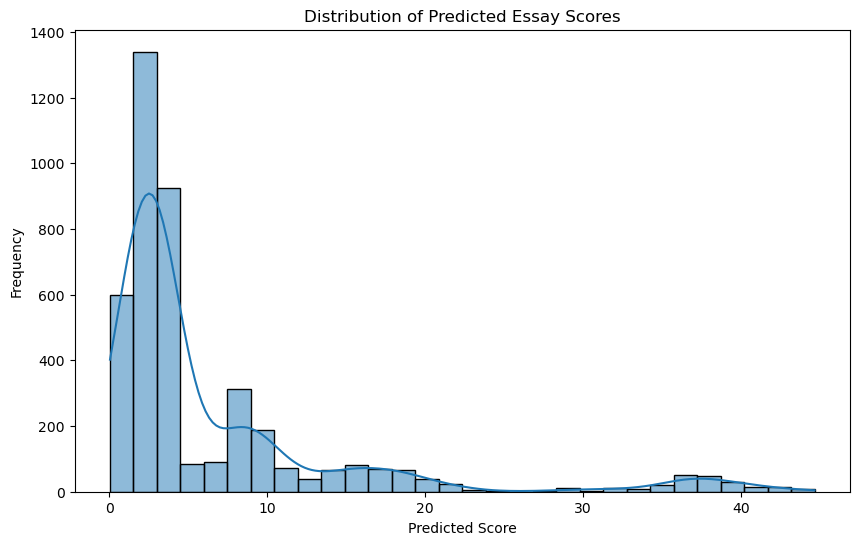

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize predictions
plt.figure(figsize=(10, 6))
sns.histplot(test_df['predicted_score'], bins=30, kde=True)
plt.title('Distribution of Predicted Essay Scores')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.show()
